In [1]:
import numpy as np
import torch
from torch import nn

from torch.nn import functional as F
import os, sys
import torch
import pickle

from tqdm import tqdm_notebook as tqdm
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Siren Exploration

This is a colab to explore properties of Light Field Networks, proposed in our work [Light Field Networks:
Neural Scene Representations with Single-Evaluation Rendering](https://vsitzmann.github.io/lfns).

We will first implement a streamlined version of LFNs for fast experimentation. This lacks the code to easily do baseline comparisons - 
please refer to the main code for that - but will greatly simplify the code!

**Make sure that you have enabled the GPU under Edit -> Notebook Settings!**

We will then reproduce the following results from the paper: 
* [Overfitting a densely sampled 3D scene using a SIREN-based LFN](#section_1)
* [Learning a multi-view consistency prior on shapenet](#section_2)

We will also explore Siren's [behavior outside of the training range](#out_of_range).

Let's go! First, some imports, and a function to quickly generate coordinate grids.

In [2]:
if not os.path.exists('tiny_nerf_data.npz'):
    !wget https://people.eecs.berkeley.edu/~bmild/nerf/tiny_nerf_data.npz
data = np.load('tiny_nerf_data.npz')

--2021-10-21 22:12:37--  https://people.eecs.berkeley.edu/~bmild/nerf/tiny_nerf_data.npz
Resolving people.eecs.berkeley.edu (people.eecs.berkeley.edu)... 128.32.244.190
Connecting to people.eecs.berkeley.edu (people.eecs.berkeley.edu)|128.32.244.190|:443... connected.
ERROR: cannot verify people.eecs.berkeley.edu's certificate, issued by ‘/C=US/ST=MI/L=Ann Arbor/O=Internet2/OU=InCommon/CN=InCommon RSA Server CA’:
  Issued certificate has expired.
To connect to people.eecs.berkeley.edu insecurely, use `--no-check-certificate'.


FileNotFoundError: [Errno 2] No such file or directory: 'tiny_nerf_data.npz'

In [2]:
with open('lego_truck.pck', 'rb') as pickle_file:
    data = pickle.load(pickle_file)

torch.Size([400, 100, 100, 3]) torch.Size([400, 4, 4]) tensor([138.8889])


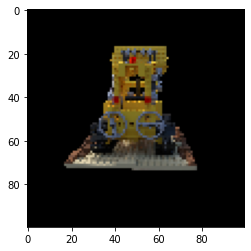

In [71]:
images = torch.Tensor(data['images']).float()
poses = torch.Tensor(data['poses']).float()
focal = torch.Tensor([data['focal']]).float()
H, W = images.shape[1:3]
print(images.shape, poses.shape, focal)

testimg, testpose = images[101], poses[101]

plt.imshow(testimg)
plt.show()

In [86]:
class SineLayer(nn.Module):
    # See paper sec. 3.2, final paragraph, and supplement Sec. 1.5 for discussion of omega_0.
    
    # If is_first=True, omega_0 is a frequency factor which simply multiplies the activations before the 
    # nonlinearity. Different signals may require different omega_0 in the first layer - this is a 
    # hyperparameter.
    
    # If is_first=False, then the weights will be divided by omega_0 so as to keep the magnitude of 
    # activations constant, but boost gradients to the weight matrix (see supplement Sec. 1.5)
    
    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        
        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        
        self.init_weights()
    
    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features, 
                                             1 / self.in_features)      
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0, 
                                             np.sqrt(6 / self.in_features) / self.omega_0)
        
    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))
    
    def forward_with_intermediate(self, input): 
        # For visualization of activation distributions
        intermediate = self.omega_0 * self.linear(input)
        return torch.sin(intermediate), intermediate
    
    
class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False, 
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()
        
        self.net = []
        self.net.append(SineLayer(in_features, hidden_features, 
                                  is_first=True, omega_0=first_omega_0))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features, 
                                      is_first=False, omega_0=hidden_omega_0))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)
            
            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0, 
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)
                
            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features, 
                                      is_first=False, omega_0=hidden_omega_0))
        
        self.net = nn.Sequential(*self.net)
    
    def forward(self, coords):
        output = self.net(coords)
        return output

In [91]:
lfn = Siren(in_features=6, hidden_features=512, hidden_layers=4, out_features=3, first_omega_0=45, outermost_linear=True)

In [92]:
def get_plucker(H, W, focal, c2w):
    i, j = torch.meshgrid(torch.arange(0, W), torch.arange(0, H))
    dirs = torch.stack([(i.float()-W*.5)/focal, (j.float()-H*.5)/focal, torch.ones_like(i).float()], -1)
#     dirs = torch.stack([(i.float()-W*.5)/focal, -(j.float()-H*.5)/focal, -torch.ones_like(i).float()], -1)
    dirs = dirs.to(c2w.device)
    
    rays_d = torch.einsum('hwd,bcd->bhwc', dirs, c2w[...,:3,:3])
    rays_o = c2w[..., None, None, :3,-1].expand(list(rays_d.shape))
    
    cross = torch.cross(rays_o, rays_d, dim=-1)
    plucker = torch.cat((rays_d, cross), dim=-1)
    return plucker

In [93]:
def render_rays(network_fn, plucker):
    return network_fn(plucker)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 3.597402572631836e-05 secs per iter


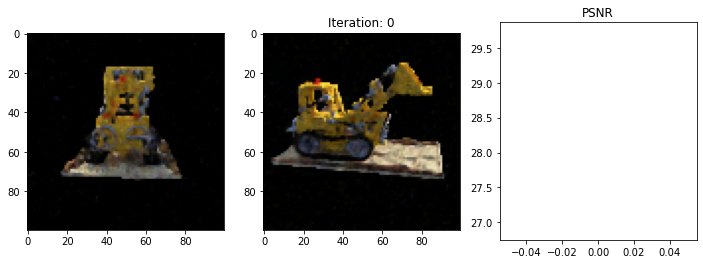

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


500 0.15440314054489135 secs per iter


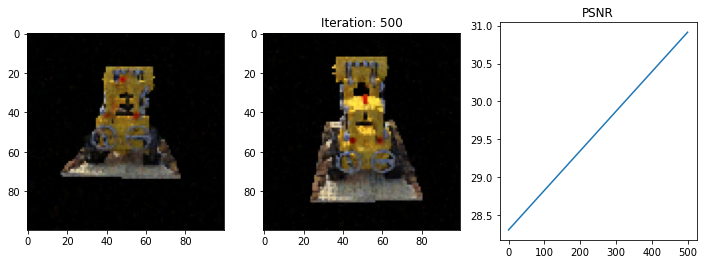

KeyboardInterrupt: 

In [97]:
N_iters = 30000
psnrs = []
iternums = []
i_plot = 500
batch_size = 20

if torch.cuda.is_available():
    lfn = lfn.cuda()
    images = images.cuda()
    poses = poses.cuda()
    testimg = testimg.cuda()
    testpose = testpose.cuda()
    
optim = torch.optim.Adam(lr=1e-5, params=lfn.parameters())

import time
t = time.time()
for i in range(N_iters+1):
    img_is = np.random.randint(images.shape[0], size=batch_size)
    target = (images[img_is] - 0.5) * 2
    pose = poses[img_is]
    plucker = get_plucker(H, W, focal, pose)

    rgb = render_rays(lfn, plucker)
    loss = ((rgb - target).square()).mean() * 200

    optim.zero_grad()
    loss.backward()
    optim.step()
    
    if i%i_plot==0:
        with torch.no_grad():
            print(i, (time.time() - t) / i_plot, 'secs per iter')
            t = time.time()

            # Render the holdout view for logging
            plucker = get_plucker(H, W, focal, testpose[None])

            rgb_test = render_rays(lfn, plucker)
            loss = (((rgb_test/2+0.5) - testimg[None]).square()).mean()
            psnr = -10. * torch.log(loss) / np.log(10.)

            psnrs.append(psnr.detach().cpu().numpy())
            iternums.append(i)

            plt.figure(figsize=(12,4))
            plt.subplot(131)
            plt.imshow((rgb_test[0].detach().cpu().numpy() + 1)/2)
            plt.subplot(132)
            plt.imshow((rgb[0].detach().cpu().numpy() +1)/2)
            plt.title(f'Iteration: {i}')
            plt.subplot(133)
            plt.plot(iternums, psnrs)
            plt.title('PSNR')
            plt.show()

In [98]:
%matplotlib inline
from ipywidgets import interactive, widgets


trans_t = lambda t : torch.Tensor([
    [1,0,0,0],
    [0,1,0,0],
    [0,0,1,t],
    [0,0,0,1],
]).float()

rot_phi = lambda phi : torch.Tensor([
    [1,0,0,0],
    [0,np.cos(phi),-np.sin(phi),0],
    [0,np.sin(phi), np.cos(phi),0],
    [0,0,0,1],
]).float()

rot_theta = lambda th : torch.Tensor([
    [np.cos(th),0,-np.sin(th),0],
    [0,1,0,0],
    [np.sin(th),0, np.cos(th),0],
    [0,0,0,1],
]).float()


def pose_spherical(theta, phi, radius):
    c2w = trans_t(radius)
    c2w = rot_phi(phi/180.*np.pi) @ c2w
    c2w = rot_theta(theta/180.*np.pi) @ c2w
    c2w = torch.Tensor([[-1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]]) @ c2w
    return c2w


def f(**kwargs):
    c2w = pose_spherical(**kwargs)
    plucker = get_plucker(H, W, focal, c2w[None, :3,:4]).cuda()
    rgb = render_rays(lfn, plucker)
    rgb /= 2.
    rgb += 0.5
    img = torch.clip(rgb,0,1)
    
    plt.figure(2, figsize=(20,6))
    plt.imshow(img[0].detach().cpu().numpy())
    plt.show()
    

sldr = lambda v, mi, ma: widgets.FloatSlider(
    value=v,
    min=mi,
    max=ma,
    step=.01,
)

names = [
    ['theta', [100., 0., 360]],
    ['phi', [-30., -90, 0]],
    ['radius', [4., 3., 5.]],
]

interactive_plot = interactive(f, **{s[0] : sldr(*s[1]) for s in names})
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(FloatSlider(value=100.0, description='theta', max=360.0, step=0.01), FloatSlider(value=-…